# Поиск неэффективных операторов

## Материалы

[Презентация к проекту](https://disk.yandex.ru/i/jTL_WeeA9iQZxg)

[Дашборд](https://public.tableau.com/views/Telecom_16738978921550/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

## Описание проекта

Компания - оператор связи "Нупозвони", клиентами которой являются колл-центры, как работающие с входящими вызовами, так и специализирующиеся на обзвонах, прорабатывает идею нового сервиса: определение неэффективных операторов колл-центров.

Входящие звонки распределяются колл-центрами операторам, также операторы совершают исходящие обзвоны и могут делать служебные внутренние вызовы внутри сети. 

**Цели проекта:** 

1. Определить пороги значений признаков неэффективности операторов:

* Количество пропущенных входящих вызовов
* Долгое ожидание ответа при входящих внешних вызовах
* Для колл-центров, специализирующихся на обзвонах - количество исходящих вызовов

2. Исходя из количества неэффективных оперторов в колл-центрах выявить долю клиентов, которым потенциально может быть интересен данный сервис.

3. Сделать выводы о потенциальной востребованности сервиса

**Требования к оформлению результатов:**

1. Основная часть проекта с проверкой гипотез и выводами в *Jupiter Notebook*
2. Презентация для менеджмента с результатами исследования в формате *PDF*
3. Дополнительно создать дашборд в Tableau Public со следующими компонентами:
* диаграмма количества вызовов по дням
* круговая диаграмма соотношения количества входящих и исходящих вызовов
* фильтр по типу вызова - внешний или внутренний

## Описание данных

`telecom_dataset.csv`:

- `user_id` — Идентификатор клиентского аккаунта колл-центра в сервисе
- `date` — Дата статистики
- `direction` — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- `internal` — Является ли звонок внутренним звонком между операторами клиента
- `operator_id` — Идентификатор оператора
- `is_missed_call` — Является ли звонок пропущенным
- `calls_count` — Количество звонков
- `call_duration` — Длительность звонка, сек (без учета времени ожидания)
- `total_call_duration` — Длительность звонка, сек (с учетом времени ожидания)

`telecom_clients.csv`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `tariff_plan` — Текущий тарифный план клиента
- `date_start` — Дата регистрации клиентв в сервисе

## План проекта:

1. [**Загрузка и предобработка данных**](#load_data)

* Чтение данных
* Общая информация, типы данных
* Пропуски в данных
* Дубликаты в данных
* Ошибки в данных
* Добавление столбца с длительностью ожидания ответа на звонок
* Добавление столбца со спецализацией колл-центра
* Итоги предобработки

2. [**Исследовательский анализ данных**](#data_analyse)

а) [Общая характеристика данных:](#data_analyse_1)
* определение периода исследования, количества клиентов и операторов
* распределение клиентов по специализации
* распределение клиентов по количеству операторов
* распределение клиентов по количеству вызовов

б) [Определение порогов для признаков неэффективности:](#data_analyse_2)
* Распределение доли неотвеченных вызовов в день в КЦ, определение порога;
* Распределение по среднему времени ожидания ответа на звонок в КЦ, определение порога;
* Распределение по среднему количеству исходящих звонков в день в КЦ, определение порога;
* Средняя продолжительность разговора на исходящих звонках, определение порога 

в) [Сбор показателей эффективности операторов, определение специализации, выявление неэффективных операторов по определённым ранее порогам](#data_analyse_3)

г) [Определение потенциальных клиентов сервиса](#data_analyse_4)
* Определить долю неэффективных операторов у клиентов;
* Определить долю колл-центров с неэффективными операторами;
* Определить, среди каких клиентов сервис может быть наиболее востребован и количество таких клиентов.

д) [Итоги исследовательского анализа](#itogi_eda)

[**3. Статистическая проверка гипотез**](#stat_1)

* Стат.различия в показателях эффективных и неэффективных операторов
* Стат.различия в показателях операторов в колл-центрах, где есть неэффективные операторы, и где таковые отсутствуют

[**4. Общие выводы**](#itogi)

**5. Презентация результатов для коллег из коммерческого департамента (PDF)**


**6. Дашборд согласно схеме (Tableau Public):**

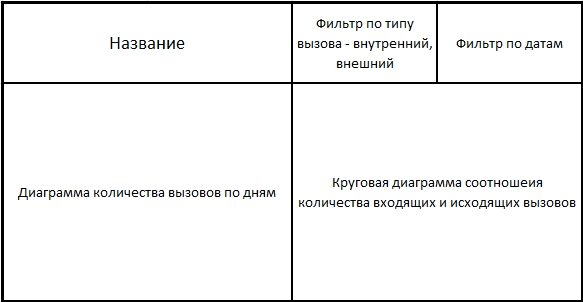

## Загрузка и предобработка данных <a class="anchor" id="load_data"></a>

### Чтение данных

Чтение данных, вывод первых строк, приведение полей с датами к соответствующему типу:

In [3]:
import pandas as pd
from urllib.parse import urlencode
import requests
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
try:
    data = pd.read_csv('telecom_dataset.csv', parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x).date)
    
except:
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = 'https://disk.yandex.ru/d/Z6Q6KHy2I_WwCA'  
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    data = pd.read_csv(download_url, parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x).date)
    
try:
    clients = pd.read_csv('telecom_clients.csv', parse_dates=['date_start'])
    
except:
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = 'https://disk.yandex.ru/d/qDyw04TLVP4CiA'  
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    clients = pd.read_csv(download_url, parse_dates=['date_start'])

In [5]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [6]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25


### Общая информация, типы данных

Выведем общую информацию о таблице **clients**, проверим на соответствие типам данных:

In [7]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


В таблице 732 записи, типы данных соответствуют.

Выведем общую информацию о датасете **data**, проверим на соответствие типам данных:

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53902 non-null  int64         
 1   date                 53902 non-null  datetime64[ns]
 2   direction            53902 non-null  object        
 3   internal             53785 non-null  object        
 4   operator_id          45730 non-null  float64       
 5   is_missed_call       53902 non-null  bool          
 6   calls_count          53902 non-null  int64         
 7   call_duration        53902 non-null  int64         
 8   total_call_duration  53902 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.3+ MB


Поля таблицы **data** соответствует описанию, в ней 53902 записи. Поле **operator_id** необходимо привести к типу **int**, остальные типы данных соответствуют.

Проверим, все ли значения в поле **operator_id** корректны:

In [9]:
count_lines = 0
count_na = 0
wrong_lines_content = []

for row in data['operator_id']:
    try:
        count_lines += 1
        level = int(row)
        
    except:
        if np.isnan(row):
            count_na += 1
        else: wrong_lines_content.append(row)
        
print(f'Всего значений: {count_lines}')
print(f'Пустых значений: {count_na}')
print(f'Некорректные значения: {wrong_lines_content}')

Всего значений: 53902
Пустых значений: 8172
Некорректные значения: []


Некорректных значений нет, есть пропуски. Приведём поле **operator_id** к типу **int** ниже, после обработки пропусков.

### Пропуски в данных

Проверим оба датасета на пропуски:

In [10]:
def na_check(df):
    data_na_sum = pd.DataFrame(df.isna().sum(), columns=['na_sum'])
    data_na_sum['na_percent'] = round(data_na_sum['na_sum'] * 100 / len(data), 2)
    display(data_na_sum.sort_values(by='na_sum', ascending=False).style.background_gradient(cmap ="coolwarm"))

na_check(clients)
na_check(data)

,na_sum,na_percent
user_id,0,0.000000
tariff_plan,0,0.000000
date_start,0,0.000000


,na_sum,na_percent
operator_id,8172,15.160000
internal,117,0.220000
user_id,0,0.000000
date,0,0.000000
direction,0,0.000000
is_missed_call,0,0.000000
calls_count,0,0.000000
call_duration,0,0.000000
total_call_duration,0,0.000000


В таблице **client** пропуски отсутствуют. В таблице **data** пропуски в полях **internal** и **operator_id**.

В таблице **data** пропуски в полях **internal** и **operator_id**.

В поле **intenal** доля пропусков около 0.2%, удалим строки с пропусками в данном поле:

In [11]:
print('Строк до удаления:', len(data))
data = data.query('not internal.isna()')
print('Cтрок после удаления:', len(data))

Строк до удаления: 53902
Cтрок после удаления: 53785


В поле **operator_id** более 15% пропусков. Посмотрим на их природу.

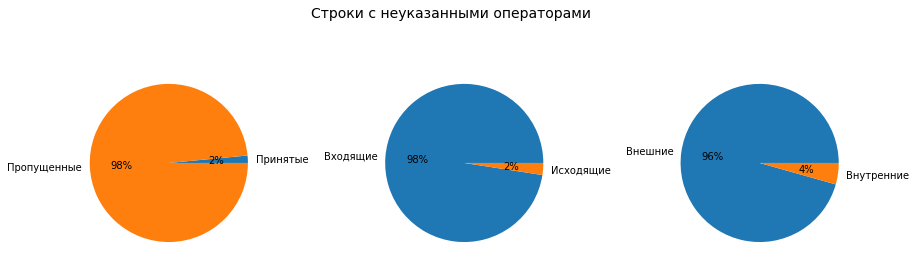

In [12]:
plt.figure(figsize=(15,8))
plt.suptitle('Строки с неуказанными операторами', size=14)
plt.subplot(2,3,1)
plt.pie(data.query('operator_id.isna()').groupby('is_missed_call')['calls_count'].count(),
        labels=['Принятые', 'Пропущенные'], autopct='%.0f%%')
plt.subplot(2,3,2)
plt.pie(data.query('operator_id.isna()').groupby('direction')['calls_count'].count(),
        labels=['Входящие', 'Исходящие'], autopct='%.0f%%')
plt.subplot(2,3,3)
plt.pie(data.query('operator_id.isna()').groupby('internal')['calls_count'].count(),
        labels=['Внешние', 'Внутренние'], autopct='%.0f%%')
plt.show()

Большая часть пропусков относится к внешним входящим пропущенным вызовам. Скорее всего, это указывает на то, что данные вызовы поступили в момент, когда все операторы заняты, и были завершены прежде, нежели успели распределиться на освободившихся операторов.

Для дальнейшего анализа заполним пропуски в поле **operator_id** значением **0** для внешних входящих пропущенных звонков:

In [13]:
print('Количество пропусков до заполнения: {0} из {1}, {2:6.2f}%'
      .format(data['operator_id'].isna().sum(), 
              len(data), 
              data['operator_id'].isna().sum()*100/len(data)))

data.loc[(data['operator_id'].isna())&
         (data['direction'] == 'in')&
         (data['internal'] == False)&
         (data['is_missed_call'] == True), 'operator_id'] = 0

print('Количество пропусков после заполнения: {0} из {1}, {2:6.2f}%'
      .format(data['operator_id'].isna().sum(), 
              len(data), 
              data['operator_id'].isna().sum()*100/len(data)))

Количество пропусков до заполнения: 8115 из 53785,  15.09%
Количество пропусков после заполнения: 579 из 53785,   1.08%


Оставшийся 1% строк с пропусками удалим из данных:

In [14]:
print('Строк до удаления:', len(data))
data = data.query('operator_id.notna()')
print('Строк после удаления:', len(data))

Строк до удаления: 53785
Строк после удаления: 53206


Приведём поле **operator_id** к типу данных **int**:

In [15]:
data['operator_id'] = data['operator_id'].astype('int')
data['operator_id'].dtype

dtype('int64')

Повторно проверим датасет на пропуски:

In [16]:
na_check(data)

,na_sum,na_percent
user_id,0,0.000000
date,0,0.000000
direction,0,0.000000
internal,0,0.000000
operator_id,0,0.000000
is_missed_call,0,0.000000
calls_count,0,0.000000
call_duration,0,0.000000
total_call_duration,0,0.000000


Пропуски обработаны. В результате в общей сложности было удалено чуть более 1% от первоначального объёма данных. 

### Дубликаты в данных

Проверим на полные дубликаты таблицу **clients**:

In [17]:
def dup_count(df):
    print('Полные дубликаты: {0} записей, {1:2.2f}% от всех записей'.format(df.duplicated().sum(), 
                                                                            df.duplicated().sum()*100/len(df)))

dup_count(clients)

Полные дубликаты: 0 записей, 0.00% от всех записей


Проверим на полные дубликаты таблицу **data**:

In [18]:
dup_count(data)

Полные дубликаты: 4845 записей, 9.11% от всех записей


Данные дубликаты скорее всего появились при выгрузке данных. Удалим их:

In [19]:
print('Количество строк до удаления полных дубликатов:', len(data))
data.drop(data[data.duplicated()].index, inplace=True)
print('Количество строк после удаления полных дубликатов:', len(data))

Количество строк до удаления полных дубликатов: 53206
Количество строк после удаления полных дубликатов: 48361


### Ошибки в данных

Выявим и удалим ошибочные строки, где звонки значатся пропущенными, а длительность разговора не равна 0 секунд, а также строки, где звонки значатся принятыми, а длительность разговора равна 0 секунд:

In [20]:
print('Количество строк до удаления:', len(data))
data.drop(data.query('(call_duration != 0 and is_missed_call == True) or (call_duration == 0 and is_missed_call == False)')
          .index, inplace=True)
print('Количество строк после удаления:', len(data))

Количество строк до удаления: 48361
Количество строк после удаления: 48049


### Добавление столбца с длительностью ожидания ответа на звонок

Будем считать время ожидания ответа на звонок как разность общего времени звонка в поле **total_call_duration** и времени разговра c оператором в поле **call_duration**. Добавим соответствующий столбец **call_waiting_time**:

In [21]:
data['call_waiting_time'] = data['total_call_duration'] - data['call_duration']
data.iloc[:,-3:].head()

,call_duration,total_call_duration,call_waiting_time
0,0,4,4
1,0,5,5
2,0,1,1
3,10,18,8
4,0,25,25


### Добавление столбца со специализацией колл-центра

Добавим столбец, в котором будет указано, на чём специализируется колл-центр: на приёме входящих вызовов, на обзвонах или на том и другом сразу.

Расчитаем долю входящих вызовов для каждого колл-центра, исключая внутренние и пропущенные вызовы, после чего добавим в исходный датасет новую колонку **user_spec** по следующему условию:

* Если входящих вызовов до 30% включительно - значение "out"
* Если входящих вызовов более 30%, но менее 70% - значение "universal"
* Если входящих вызовов от 30% включительно - значение "in"
* Если в колл-центре не было ни одного внешнего звонка - значение "inactive"

In [22]:
def user_spec_definition(data_calls, percent=30):
    '''Функция возвращает датафрейм с user_id клиента и его специализацией user_spec по условию:
    
    Если входящих вызовов до <percent>% включительно - значение "out"
    Если входящих вызовов более <percent>%, но менее 100-<percent>% - значение "universal"
    Если входящих вызовов от <percent>% включительно - значение "in"
    Если в колл-центре не было ни одного внешнего звонка - значение "inactive"
    При расчёте доли входящих вызовов исключаются внутренние и пропущенные вызовы
    
    Параметры: 

    data_calls: агрегированный датафрейм с информацией по звонкам
    percent=20: пороговое значение процента входящих вызовов
    '''
    
    calls_d_count = data_calls.query('internal == False and is_missed_call == False').pivot_table(index='user_id',
                                            columns='direction',
                                            values='calls_count',
                                            aggfunc='sum').fillna(0).reset_index()

    user_spec = []

    for x in range(0, len(calls_d_count)):
        in_part = round(calls_d_count.iloc[x,1]/(calls_d_count.iloc[x,1]+calls_d_count.iloc[x,2]),2)
        if in_part <= percent/100:
            user_spec.append('out')
        elif in_part > percent/100 and in_part < (1 - percent/100):
            user_spec.append('universal')
        elif in_part >= (1-percent/100):
            user_spec.append('in')
        else: user_spec.append('inactive')
            
    calls_d_count = pd.DataFrame({'user_spec':user_spec}, index=calls_d_count['user_id'])
        
    return calls_d_count

In [23]:
data = data.join(user_spec_definition(data, percent=30), on='user_id', how='left')
data['user_spec'].fillna('inactive', inplace=True)

### Итоги предобработки

Таблица **clients**:
* В таблице 732 записи
* Пропуски и полные дубликаты отсутствуют

Таблица **data**:
* В изначальном датасете 53902 записи
* Удалены строки с пропусками в поле **internal**, 0.2% от общего количества строк
* Обработаны пропуски в поле **operator_id**, 15% от общего количества строк: 98% пропусков, предположительно означающих не назначенные операторам пропущенные вызовы, заменены значением "0", остальные (1% от общего объёма данных) - удалены
* Обнаружены и удалены 4845 записей, являющиеся полными дубликатами.
* Обнаружены и удалены 312 записей, где звонки числятся принятыми, а длительность разговора 0, либо где звонки значатся пропущенными, а длительность разговора не равна 0.
* Добавлен столец **call_waiting_time** с временем ожидания ответа на звонок.
* Добавлен столец **user_spec** с временем ожидания ответа на звонок.
* Итоговый объём очищенных данных - 48049 записей.

## Исследовательский анализ <a class="anchor" id="data_analyse"></a>

### Общая характеристика данных <a class="anchor" id="data_analyse_1"></a>

Определим период исследования:

In [24]:
print('Первый день в датасете: {:%Y-%m-%d}'.format(data.date.min()))
print('Последний день в датасете: {:%Y-%m-%d}'.format(data.date.max()))

Первый день в датасете: 2019-08-02
Последний день в датасете: 2019-11-28


Данные собраны за период с 2 августа по 28 ноября 2019г. 

Проверим, сколько клиентов оказалось в каждой специализации:

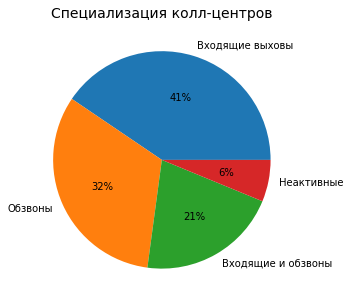

,Специализация,Количество клиентов
0,in,124
2,out,99
3,universal,64
1,inactive,19


In [25]:
num_users_spec = data.groupby('user_spec', as_index=False)['user_id'].nunique().sort_values(by='user_id', ascending=False)
num_users_spec.columns=['Специализация', 'Количество клиентов']

plt.figure(figsize=(5,5))
plt.title('Специализация колл-центров', size=14)
plt.pie(num_users_spec['Количество клиентов'], labels=['Входящие выховы', 'Обзвоны', 'Входящие и обзвоны', 'Неактивные'], autopct='%.0f%%')
plt.show()
display(num_users_spec)

* Наибольшая доля приходится на колл-центры, специализирующихся на входящих вызовах - 41%
* Около трети клиентов, 32%, специализируются на исходящих вызовах
* Пятая часть, 21%, совершают входящие и исходящие звонки в примерно равной степени
* 6% колл-центров определены как неактивные, т.к за исследуемый период за ними не числится состоявшихся внешних звонков.

Взглянем на распределение количества операторов в колл-центрах:

In [26]:
def distr_plot(df_col, title, label): #функция графиков распределения
    x_values = pd.Series(range(0,len(df_col)))
    plt.figure(figsize=(15,6))
    plt.suptitle(title, size=14)
    
    plt.subplot(1,2,1)
    plt.scatter(x_values, df_col)
    plt.ylabel(label)
    plt.grid(axis='y')
    
    plt.subplot(1,4,3)
    sns.boxplot(y=df_col)
    plt.ylabel(label)
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.show()

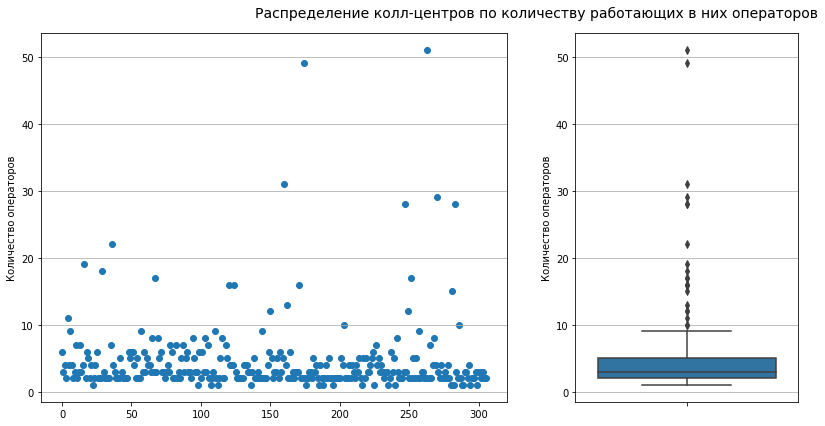

Общее количество колл-центров, пользовавшихся услугами в исследуемый период: 306
Общее количество операторов, совершавших и принимавших вызовы: 1093
В 90% колл-центров работали операторы количеством не более: 8


In [27]:
distr_plot(data.groupby('user_id')['operator_id'].nunique(),
           'Распределение колл-центров по количеству работающих в них операторов',
           'Количество операторов')

print('Общее количество колл-центров, пользовавшихся услугами в исследуемый период:', 
      len(data.user_id.unique()))
print('Общее количество операторов, совершавших и принимавших вызовы:', 
      len(data.operator_id.unique()))
print('В 90% колл-центров работали операторы количеством не более:', 
      round(np.percentile(data.groupby('user_id')['operator_id'].nunique(), 90)))

Общее количество операторов, работавших в системе за исследуемый период, достаточно для анализа.

Поскольку компании с большим штатом операторов могут острее нуждаться в мониторинге их работы, они могут быть более  заинтересованы в нашем сервисе, однако таких немного, лишь 10% клиентов имеют более 8 операторов в штате.

Посмотрим на распределение колл-центров по среднему количеству принятых/совершённых вызовов в день, только для дней, когда эти вызовы совершались:

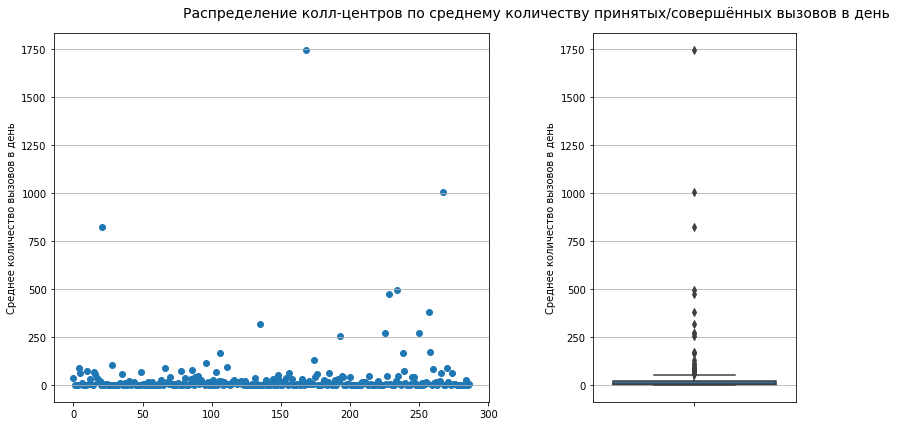

90% колл-центров совершили/приняли вызовов в день в среднем не более: 65


In [28]:
client_day_calls_mean = round(data.query('is_missed_call == False')
                              .groupby('user_id')['calls_count'].sum() / 
                              data.query('is_missed_call == False')
                              .groupby('user_id')['date'].nunique()).astype(int)

distr_plot(client_day_calls_mean,
           'Распределение колл-центров по среднему количеству принятых/совершённых вызовов в день',
           'Среднее количество вызовов в день')

print('90% колл-центров совершили/приняли вызовов в день в среднем не более:', 
      round(np.percentile(client_day_calls_mean, 90)))

Среди наших клиентов есть особенно загруженные звонками. Возможно, такие клиенты также заинтересуются новым сервисом в первую очередь.

### Определение критериев неэффективности операторов и порогов неэффективности <a class="anchor" id="data_analyse_2"></a>

#### Доля неотвеченных вызовов в день

Посмотрим на распределение операторов по доле неотвеченных вызовов среди входящих, включая внутренние.
При этом в расчёт не берём операторов колл-центров, которые не сециализируются на приёме звонков. 
Дни, когда оператор не работал, а также звонки, не назначенные на конкретного оператора, не учитываем.

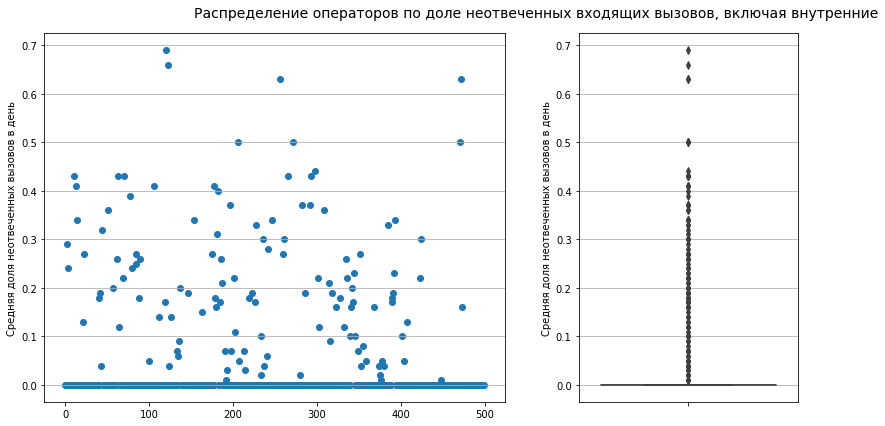

In [29]:
calls_missed = (data.query('operator_id != 0 and direction == "in" and user_spec in ["in", "universal"]')
            .groupby(['operator_id','is_missed_call'], as_index=False)
            .agg({'date':'nunique','calls_count':'sum'})
           )

calls_missed['calls_per_day'] = calls_missed['calls_count'] / calls_missed['date']

calls_missed = calls_missed.pivot_table(index='operator_id', columns='is_missed_call', values='calls_per_day').fillna(0)

calls_missed.columns = ['non_missed_per_day', 'missed_per_day']

calls_missed['missed_frac_per_day'] = (round(calls_missed['missed_per_day'] / 
                                          (calls_missed['missed_per_day'] + 
                                           calls_missed['non_missed_per_day']),2)
                                         )

distr_plot(calls_missed['missed_frac_per_day'],
           'Распределение операторов по доле неотвеченных входящих вызовов, включая внутренние',
           'Средняя доля неотвеченных вызовов в день')

Определим порог неэффективности по **percentile 90**:

In [30]:
percentile = 80

missed_calls_limit=round(np.percentile(calls_missed['missed_frac_per_day'], percentile), 2)

print(f'{percentile}% операторов пропускают в день вызовов, не более: {missed_calls_limit*100}%')

80% операторов пропускают в день вызовов, не более: 7.000000000000001%


#### Среднее время ответа на звонок

Возьмём среднее время ожидания ответа на входящий звонок за весь период. При расчёте этого критерия не учитываем операторов колл-центров, которые не специализируются на приёме звонков. 

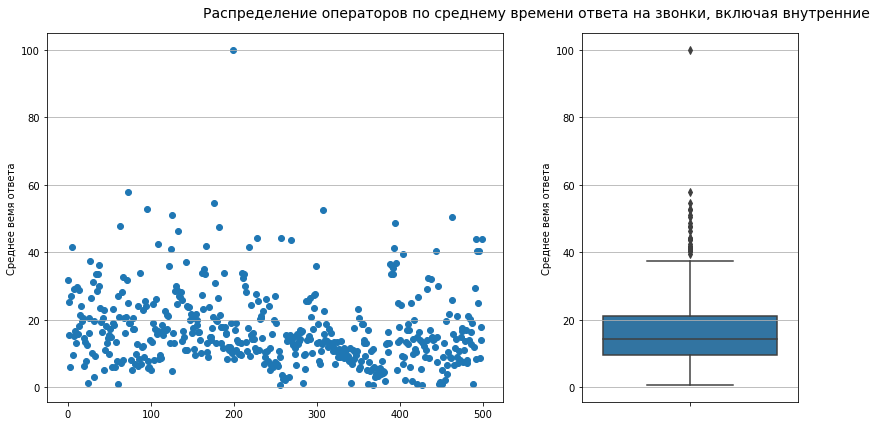

In [31]:
med_wait_time = (data.query('user_spec in ["in", "universal"] and direction == "in" and is_missed_call == False')
             .groupby('operator_id').agg({'call_waiting_time':'sum', 'calls_count':'sum'})
            )

med_wait_time['waiting_time'] = med_wait_time['call_waiting_time'] / med_wait_time['calls_count']

distr_plot(med_wait_time['waiting_time'],
           'Распределение операторов по среднему времени ответа на звонки, включая внутренние',
           'Среднее вемя ответа')

In [32]:
percentile = 90

med_wait_time_limit=round(np.percentile(med_wait_time['waiting_time'], percentile))

print(f'У {percentile}% операторов среднее время ответа на звонок составляет не более {med_wait_time_limit} сек')

У 90% операторов среднее время ответа на звонок составляет не более 32 сек


#### Количество исходящих звонков в день

Данный критерий эффективности работы - только для колл-центров, специализирующихся на обзвонах. Посмотрим на распределение в таких колл-центрах операторов по среднему количеству исходящих вызовов в день, при этом принимаем в расчёт только вызовы, которые были приняты. Дни, когда оператор не работал, не учитываем.

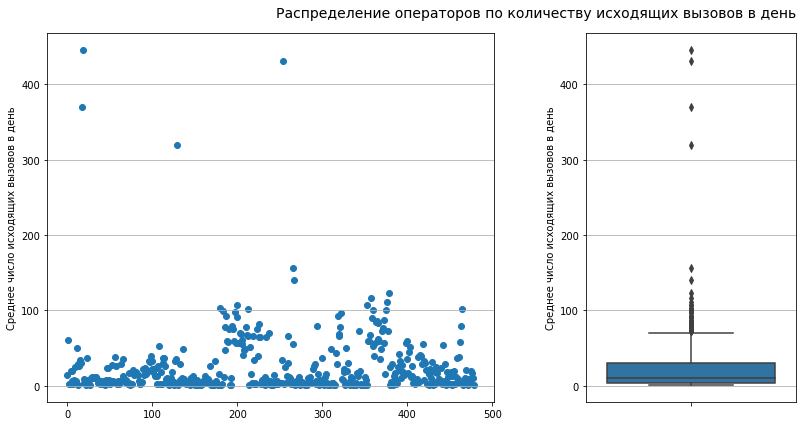

In [33]:
calls_out = (data.query('user_spec == "out" and direction == "out" and is_missed_call == False')
             .groupby('operator_id').agg({'date':'nunique', 'calls_count':'sum'})
            )

calls_out['calls_per_date'] = (calls_out['calls_count'] / calls_out['date'])

distr_plot(calls_out['calls_per_date'],
           'Распределение операторов по количеству исходящих вызовов в день',
           'Среднее число исходящих вызовов в день')

Определим порог неэффективности по **percentile 20**:

In [34]:
percentile=20

calls_out_limit=round(np.percentile(calls_out['calls_per_date'], percentile))

print(f'{percentile}% операторов совершают в день вызовов, не более: {calls_out_limit}')

20% операторов совершают в день вызовов, не более: 3


#### Средняя продолжительность разговора исходящего звонка

Данный критерий эффективности работы - только для колл-центров, специализирующихся на обзвонах. Он может характеризовать, насколько долго оператор может поддерживать интерес собеседника. При расчёте критерия принимаются в расчёт только состоявшиеся внешние исходящие звонки.

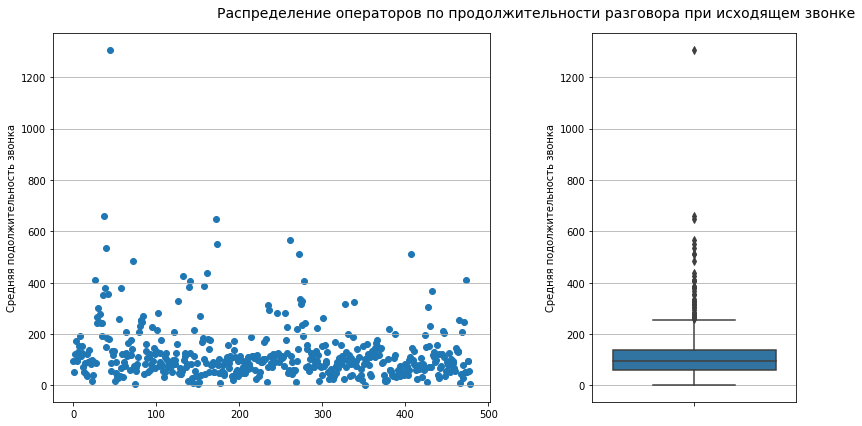

In [35]:
calls_out_duration = (data.query('user_spec == "out" and direction == "out" and is_missed_call == False')
             .groupby('operator_id').agg({'call_duration':'sum', 'calls_count':'sum'})
            )
calls_out_duration['call_med_duration'] = calls_out_duration['call_duration'] / calls_out_duration['calls_count']

distr_plot(calls_out_duration['call_med_duration'],
           'Распределение операторов по продолжительности разговора при исходящем звонке',
           'Средняя подолжительность звонка')

In [36]:
percentile=10

calls_out_duration_limit=round(np.percentile(calls_out_duration['call_med_duration'], percentile))

print(f'{percentile}% операторов удерживают разговор при исходящем вызове в среднем менее {calls_out_duration_limit} сек')

10% операторов удерживают разговор при исходящем вызове в среднем менее 37 сек


Выведем сводную информацию о порогах неэффективности:

In [37]:
print('Для входящих: порог по средней доле пропущенных вызовов в день, не более:', missed_calls_limit)
print('Для входящих: порог по среднему времени ожидания ответа на вызов, сек не более:', med_wait_time_limit)
print('Для исходящих: порог по исходящим вызовам в день, не менее:', calls_out_limit)
print('Для исходящих: порог срдней продолжительности разговора, не менее:', calls_out_duration_limit)

Для входящих: порог по средней доле пропущенных вызовов в день, не более: 0.07
Для входящих: порог по среднему времени ожидания ответа на вызов, сек не более: 32
Для исходящих: порог по исходящим вызовам в день, не менее: 3
Для исходящих: порог срдней продолжительности разговора, не менее: 37


### Сбор датафрейма с показателями операторов, определение неэффективных операторов <a class="anchor" id="data_analyse_3"></a>

Поскольку в датасете присутствует большая доля клиентов, где количество входящих и исходящих вызовов сопоставимо, это вызывает определённые трудности с индивидуализацией подхода к оценке эффективности операторов исходя из специализации колл-центра.

В одном колл-центре могут работать операторы с разной ролью - как совершать исходящие звонки, так и принимать входящие.

Соберём показатели эффективности по всем операторам, определим их роль (работают ли они на входящих или исходящих звонках) и далее оценим их эффективность исходя из их роли, а если её определить невозможно - исходя из специализации колл-центра.

Напишем функцию для формирования таблицы с показателями эффективности операторов. В таблицу войдут:
* все указанные ранее показатели эффективности, но рассчитанные по каждому оператору, без привязки к специализации колл-центра;
* id колл-центра оператора;
* доля входящих вызовов среди всех состоявшихся вызовов, как показатель специализации оператора.

In [38]:
def create_ops_tab(data_calls):
    '''
        Функция принимает датафрейм с данными звонков и возвращает датафрейм с показателями эффективности операторов.
        
        Поля возвращаемого датафрейма:
        operator_id (index) - id оператора
        user_id - id колл-центра
        frac_in_out - доля входящих вызовов (показатель специализации оператора)
        missed_frac_per_day - доля пропущенных входящих вызовов в день
        waiting_time - среднее время ожидания входящего звонка
        calls_per_date - среднее количество исходящих звонков в день
        calls_missed - количество пропущенных входящих вызовов в день
        call_med_duration - средняя продолжительность разговора для исходящих звонков
        
    '''

    #Количество пропущенных входящих вызовов в день
    calls_missed = (data_calls.query('operator_id != 0 and direction == "in"')
                    .groupby(['operator_id','is_missed_call'], as_index=False)
                    .agg({'date':'nunique','calls_count':'sum'})
                   )
    calls_missed['calls_per_day'] = calls_missed['calls_count'] / calls_missed['date']
    calls_missed = calls_missed.pivot_table(index='operator_id', columns='is_missed_call', values='calls_per_day').fillna(0)
    calls_missed.columns = ['non_missed_per_day', 'missed_per_day']
    calls_missed['missed_frac_per_day'] = (calls_missed['missed_per_day'] / 
                                          (calls_missed['missed_per_day'] + 
                                           calls_missed['non_missed_per_day']))
    calls_missed.drop(['non_missed_per_day', 'missed_per_day'], axis=1, inplace=True)

    #Среднее время ожидания ответа на звонок для входящих вызовов
    med_wait_time = (data_calls.query('operator_id != 0 and direction == "in" and is_missed_call == False')
                     .groupby('operator_id').agg({'call_waiting_time':'sum', 'calls_count':'sum'})
                    )
    med_wait_time['waiting_time'] = med_wait_time['call_waiting_time'] / med_wait_time['calls_count']
    med_wait_time.drop(['call_waiting_time', 'calls_count'], axis=1, inplace=True)

    #Количество состоявшихся исходящих вызовов в день
    calls_out = (data_calls.query('operator_id != 0 and direction == "out" and is_missed_call == False')
                 .groupby('operator_id').agg({'date':'nunique', 'calls_count':'sum'})
                )
    calls_out['calls_per_date'] = (calls_out['calls_count'] / calls_out['date'])
    calls_out.drop(['date', 'calls_count'], axis=1, inplace=True)
    
    #Средняя продолжительность разговора исходящего звонка
    calls_out_duration = (data_calls.query('operator_id != 0 and direction == "out" and is_missed_call == False')
                          .groupby('operator_id').agg({'call_duration':'sum', 'calls_count':'sum'})
                         )
    calls_out_duration['call_med_duration'] = calls_out_duration['call_duration'] / calls_out_duration['calls_count']
    calls_out_duration.drop(['call_duration', 'calls_count'], axis=1, inplace=True)
    
    #Доля входящих вызовов
    calls_in_out = (data_calls.query('operator_id != 0 and is_missed_call == False').pivot_table(index='operator_id',
                                                                       columns='direction',
                                                                       values='calls_count',
                                                                       aggfunc='sum').fillna(0)
                    )
    calls_in_out['frac_in_out'] = calls_in_out['in'] / (calls_in_out['in'] + calls_in_out['out'])
    calls_in_out.drop(['in', 'out'], axis=1, inplace=True)
    calls_in_out.columns = ['frac_in_out']

    #id колл-ценра
    operators = data_calls.query('operator_id != 0').groupby('operator_id').agg({'user_id':'first'})

    #объединение в единую таблицу
    operators_ind = (operators.join(calls_in_out)
                 .join(calls_missed)
                 .join(med_wait_time)
                 .join(calls_out)
                 .join(calls_out_duration)
                )
    
    return(operators_ind)

In [39]:
ops_tab = create_ops_tab(data)
ops_tab.head()

,user_id,frac_in_out,missed_frac_per_day,waiting_time,calls_per_date,call_med_duration
operator_id,,,,,,
879896,166406,0.085420,0.0,9.896552,13.800000,93.793881
879898,166406,0.020800,0.0,16.242718,61.379747,51.771087
880020,166377,0.304348,0.0,7.714286,2.666667,121.625000
880022,166377,0.086957,0.0,14.000000,2.545455,174.226190
880026,166377,0.015152,0.0,5.958333,20.259740,97.268590


Чтобы определить набор критериев для оценки эффективности (для входящих вызовов или исходящих), определим специализацию операторов, внесём эту информацию в отдельный столбец **op_spec**:
* до 35% включительно входящих вызовов - оцениваем исходя из критериев эффективности для исходящих вызовов (значение **out**)
* от 65% и выше входящих вызовов - оцениваем исходя из критериев для входящих вызовов (значение **in**)
* Если специализация оператора не очевидна - в зависимости от специализации колл-центра.
* Если специализация колл-центра не определена- применяем критерии для входящих звонков.  

In [40]:
def ops_type_definition(ops_df, clients_df, percent=35):

    '''Функция возвращает датафрейм с id оператора и его специализацией op_spec по условию:
        Если входящих вызовов до <percent>% включительно - значение "out"
        Если входящих вызовов от 100-<percent>% включительно - значение "in"
        В остальных случаях - значение поля со специализацией колл-центра ("in"/"out")
        Если специализация колл-центра тоже не определена - значение "in"
    
        Параметры: 

        ops_df: датафрейм с id оператора в индексе, полем id колл-центра 'user_id' и полем с долей входящих звонков 'frac_in_out'
        clients_df: датафрейм с id колл-центра в индексе и полем 'user_spec' со специализацией колл-центра
        percent=35: пороговое значение процента входящих вызовов для определения специализации оператора  
    '''
    
    ops_df = (ops_df[['user_id', 'frac_in_out']]
              .join(clients_df.query('user_spec in ["in", "out"]'), 
                    on='user_id', 
                    how='left')
             )
    ops_df['op_spec'] = np.where(ops_df['frac_in_out']<=percent/100, 'out',
                                np.where(ops_df['frac_in_out']>=1-percent/100, 'in', None))
    ops_df.loc[ops_df['op_spec'].isna(), 'op_spec'] = ops_df.loc[ops_df['op_spec'].isna(), 'user_spec']
    ops_df['op_spec'].fillna('in', inplace=True)
    
    return ops_df.drop(['user_id', 'frac_in_out', 'user_spec'], axis=1)

In [41]:
ops_tab = ops_tab.join(ops_type_definition(ops_tab, user_spec_definition(data, percent=30), percent=35), how='left')
ops_tab.head()

,user_id,frac_in_out,missed_frac_per_day,waiting_time,calls_per_date,call_med_duration,op_spec
operator_id,,,,,,,
879896,166406,0.085420,0.0,9.896552,13.800000,93.793881,out
879898,166406,0.020800,0.0,16.242718,61.379747,51.771087,out
880020,166377,0.304348,0.0,7.714286,2.666667,121.625000,out
880022,166377,0.086957,0.0,14.000000,2.545455,174.226190,out
880026,166377,0.015152,0.0,5.958333,20.259740,97.268590,out


Датафрейм с данными, необходимыми для определения неэффективных операторов, собран. 

Пометим неэффективных операторов в отдельном булевом столбце **inefficient**.

Будем считать оператора неэффективным, если хотя бы один его показатель в соответствии со специализацией выходит за пороговое значение. Пороговые значения критериев эффективности определены нами ранее.

In [48]:
ops_tab['inefficient'] = np.where((ops_tab['missed_frac_per_day']>missed_calls_limit)&(ops_tab['op_spec'] == "in"), True, 
                        np.where((ops_tab['waiting_time']>med_wait_time_limit)&(ops_tab['op_spec'] == "in"), True,
                        np.where((ops_tab['calls_per_date']<calls_out_limit)&(ops_tab['op_spec'] == "out"), True,
                        np.where((ops_tab['call_med_duration']<calls_out_duration_limit)&(ops_tab['op_spec'] == "out"), True,
                        False))))
ops_tab.head()

,user_id,frac_in_out,missed_frac_per_day,waiting_time,calls_per_date,call_med_duration,op_spec,inefficient
operator_id,,,,,,,,
879896,166406,0.085420,0.0,9.896552,13.800000,93.793881,out,False
879898,166406,0.020800,0.0,16.242718,61.379747,51.771087,out,False
880020,166377,0.304348,0.0,7.714286,2.666667,121.625000,out,True
880022,166377,0.086957,0.0,14.000000,2.545455,174.226190,out,True
880026,166377,0.015152,0.0,5.958333,20.259740,97.268590,out,False


Неэффективные операторы определены. Посмотрим на их долю и на распределение по колл-центрам:

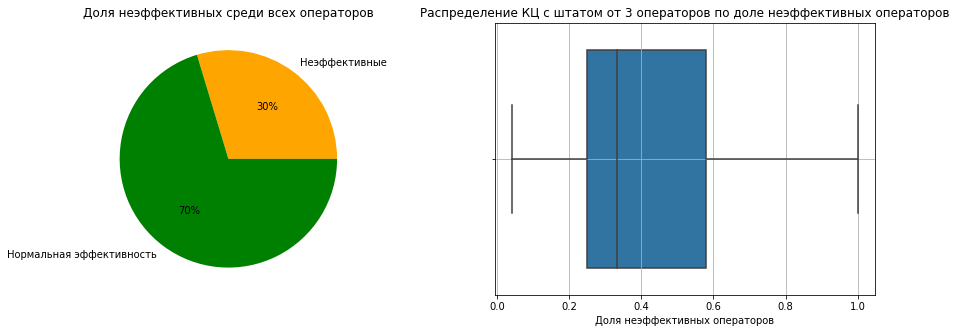

In [49]:
users_ops_eff = ops_tab.reset_index().groupby('user_id').agg({'operator_id':'nunique','inefficient':'sum'})
users_ops_eff['inefficient_coef'] = users_ops_eff['inefficient'] / users_ops_eff['operator_id']
users_ops_eff.columns=['ops_all', 'ops_inefficient', 'inefficient_coef']

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.pie([ops_tab['inefficient'].sum(), len(ops_tab.query('inefficient == False')['inefficient'])], labels=['Неэффективные', 'Нормальная эффективность'], colors=['orange','green'], autopct='%.0f%%')
plt.title('Доля неэффективных среди всех операторов')
plt.grid(True)
plt.subplot(1,2,2)
sns.boxplot(x=users_ops_eff.query('inefficient_coef > 0 and ops_all >= 3')['inefficient_coef'])
plt.title('Распределение КЦ с штатом от 3 операторов по доле неэффективных операторов')
plt.xlabel('Доля неэффективных операторов')
plt.grid()
plt.show()

Четверть всех операторов определены как неэффективные. В большей части колл-центров, где в штате присутствуют неэффективные операторы и сам штат от 3 операторов, доля неэффективных операторов от 30% до 50%.

### Определение потенциальных клиентов сервиса <a class="anchor" id="data_analyse_4"></a>

Определим, среди каких клиентов сервис может быть наиболее востребован.

Будем считать, что потенциальные клиенты сервиса обладают следующими характеристиками:

* имеют в штате неэффективных оераторов
* количество операторов в штате - от трёх и выше
* средняя нагрузка на колл-центр - от 10 состоявшихся разговоров в день

Выведем информацию по соответствию колл-центров вышеназваным критериям:

In [50]:


#список КЦ, имеющих в штате неэффективных операторов
users_with_ineff_ops = users_ops_eff.query('inefficient_coef > 0').index

#список КЦ, имеющих в штате от трёх и выше операторов за исследуемый период
users_with_many_ops = data.groupby('user_id', as_index=False)['operator_id'].nunique().query('operator_id >= 3')['user_id']

#список КЦ со средней нагрузкой на КЦ от 10 разговоров в день
users_with_many_day_calls = client_day_calls_mean[client_day_calls_mean >= 10].index

#Собираем в датафрейм
users_with_interest = pd.DataFrame({'user_id':clients['user_id'],
                                   'ineff_ops':np.where(clients['user_id'].isin(users_with_ineff_ops), 1, 0),
                                   'many_ops':np.where(clients['user_id'].isin(users_with_many_ops), 1, 0),
                                   'many_day_calls':np.where(clients['user_id'].isin(users_with_many_day_calls), 1, 0)})

users_with_interest['total_interest'] =  (users_with_interest['ineff_ops'] +
                                         users_with_interest['many_ops'] + 
                                         users_with_interest['many_day_calls'])
users_with_interest.head()

,user_id,ineff_ops,many_ops,many_day_calls,total_interest
0,166713,0,1,0,1
1,166901,1,1,1,3
2,168527,0,0,0,0
3,167097,0,0,0,0
4,168193,0,1,1,2


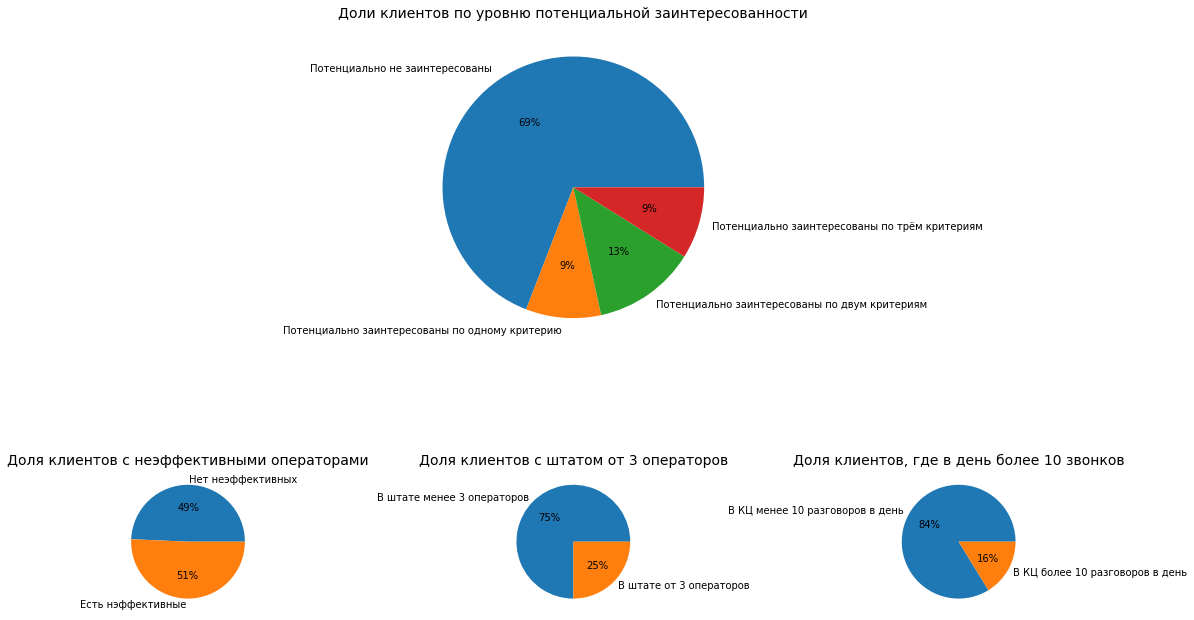

In [51]:
users_interest = users_with_interest.groupby('total_interest')['user_id'].count()
users_with_interest.groupby('many_ops')['many_ops'].count()

plt.figure(figsize=(15,10))

plt.subplot(2,3,4)
plt.pie([len(users_ops_eff.query('inefficient_coef==0')), 
         len(users_ops_eff.query('inefficient_coef>0'))], 
        labels=['Нет неэффективных', 'Есть нэффективные'],
        autopct='%.0f%%')
plt.title('Доля клиентов c неэффективными операторами', size=14)

plt.subplot(2,3,5)
plt.pie([len(users_with_interest.query('many_ops == 0')),
         len(users_with_interest.query('many_ops == 1'))],
        labels=['В штате менее 3 операторов', 'В штате от 3 операторов'], 
        autopct='%.0f%%')
plt.title('Доля клиентов с штатом от 3 операторов', size=14)

plt.subplot(2,3,6)
plt.pie([len(users_with_interest.query('many_day_calls == 0')),
         len(users_with_interest.query('many_day_calls == 1'))],
        labels=['В КЦ менее 10 разговоров в день', 'В КЦ более 10 разговоров в день'],
        autopct='%.0f%%')
plt.title('Доля клиентов, где в день более 10 звонков', size=14)

plt.subplot(2,1,1)
plt.pie(users_interest, labels=['Потенциально не заинтересованы',
                                'Потенциально заинтересованы по одному критерию',
                                'Потенциально заинтересованы по двум критериям',
                                'Потенциально заинтересованы по трём критериям'], autopct='%.0f%%')
plt.title('Доли клиентов по уровню потенциальной заинтересованности', size=14)

plt.tight_layout()
    
plt.show()

In [52]:
users_with_interest.groupby('many_ops')['many_ops'].count()

many_ops
0    549
1    183
Name: many_ops, dtype: int64

Получены следующие результаты:
    
* Неэффеективные операторы определены в 46% колл-центров;
* Штат, состоящий из не менее 3 операторов - у 25% колл-центров;
* Доля колл-центров, где в день совершается более 10 звонков, составляет 16%

При этом одним из вышеназванных признаков обладает 9% клиентов, двумя - 13%, тремя - 8%.

Всего доля потенциальных клиентов, которая обладает хотя бы одним признаком потенциальной заинтересованности в сервисе - 30%

### Итоги исследовательского анализа <a class="anchor" id="itogi_eda"></a>

**Общая информация:**

1. Данные собраны за период с 2 августа по 28 ноября 2019г. 
2. Количество колл-центров, пользовавшихся услугами: 306. Количество операторов, совершавших и принимавших вызовы: 1093
3. В 90% колл-центров штат операторов не превышает 8, также в 90% колл-центров совершено/принято не более 65 вызовов в день
4. По специализация колл-центры распределились следующим образом:
* 41% специализируются на входящих вызовах (у них более 70% входящих вызовов)
* 32% специализируются на исходящих вызовах (у них более 70% исходящих вызовов)
* 21% совершают входящие и исходящие звонки примерно в равной степени
* в 6% колл-центров не совершалось внешних звонков за исследуемый период.

**Признаки неэффективности и пороги**

1. Средняя доля пропущенных вызовов в день: порог эффективности определён на уровне не более 22% пропущенных вызовов для операторов, специализирующихся на входящих вызовах.
2. Среднее время ожидания ответа на вызов: не более 32 секунд для операторов, специализирующихся на входящих вызовах
3. Количество исходящих вызовов в день: не менее 3, установлен для операторов, специализирующихся на исходящих вызовах.
4. Средняя продолжительность разговора: не менее 37 секунда, установлен для операторов, специализирующихся на исходящих вызовах.

**Результаты анализа эффективности операторов**

1. Четверть всех операторов определены как неэффективные.Такие операторы определены в 46% колл-центров.
2. Доля неэффективных операторов в большинстве колл-центров, где такие операторы есть - от 30% до 50%.

**Колл-центры, потенциально заинтересованные в новом сервисе**
1. Неэффеективные операторы определены в 46% колл-центров;
2. Штат, состоящий из не менее 3 операторов - у 25% колл-центров;
3. Доля колл-центров, где в день совершается более 10 звонков, составляет 16%;
4. Одним из вышеназванных признаков обладает 9% клиентов, двумя - 13%, тремя - 8%;
5. Всего доля потенциальных клиентов, которая обладает хотя бы одним признаком потенциальной заинтересованности в сервисе - 30%.

## Проверка статистических гипотез <a class="anchor" id="stat_1"></a>

### Стат. различия в показателях эффективных и неэффективных операторов

Ранее мы посчитали неэффективными операторов, вышедших за порог хотя бы по одному из двух критериев эффективности для своей специализации.

Теперь проверим, что различия по всем критериям для каждой специализации у эффективных и неэффективных операторов статистически значимы.

Проведём тесты по каждому признаку неэффективности для операторов, специализирующихся на входящих и исходящих вызовах.

Сформулируем гипотезы для первого признака неэффективности:
* Н0: Среднее время ожидания ответа на звонок для эффекивных и неэффективных операторов не отличается
* Н1: Среднее время ожидания ответа на звонок для эффективных и неэффективных операторов отличается

Сформируем выборки и проведём тест. Уровень значимости alpha примем 0.05 и применим поправку Бонферрони для четырёх тестов:

In [53]:
alpha = 0.05/4

In [54]:
def hyp_ttest(sample_a, sample_b):
    
    sample_a = sample_a[sample_a.notna()]
    sample_b = sample_b[sample_b.notna()]
    
    print('P-Value: {0:.50f}'.format(stats.ttest_ind(sample_a, sample_b)[1]))
    
    if stats.ttest_ind(sample_a, sample_b)[1] <= alpha:
        print('Есть основания отвергнуть нулевую гипотезу')
    else:
        print('Нет оснований отвергнуть нулевую гипотезу')
    print("Относительное отличие среднего показателя в группе B: {0:.3f}"
      .format(sample_b.mean() / sample_a.mean() - 1))

In [55]:
sample_a = ops_tab.query('inefficient == False and op_spec == "in"')['waiting_time']
sample_b = ops_tab.query('inefficient == True and op_spec == "in"')['waiting_time']

hyp_ttest(sample_a, sample_b)

P-Value: 0.00000000000000000000000000003910911374545393114005
Есть основания отвергнуть нулевую гипотезу
Относительное отличие среднего показателя в группе B: 0.875


Сформулируем гипотезы для второго признака неэффективности:
* Н0: Среднее количество пропущенных в день вызовов для эффекивных и неэффективных операторов не отличается
* Н1: Среднее количество пропущенных в день вызовов для эффекивных и неэффективных операторов отличается

In [56]:
sample_a = ops_tab.query('inefficient == False and op_spec == "in"')['missed_frac_per_day']
sample_b = ops_tab.query('inefficient == True and op_spec == "in"')['missed_frac_per_day']

hyp_ttest(sample_a, sample_b)

P-Value: 0.00000000000000000000000000000000000000000000000000
Есть основания отвергнуть нулевую гипотезу
Относительное отличие среднего показателя в группе B: 71.945


Сформулируем гипотезы для третьего признака неэффективности:
* Н0: Средняя продолжительность звонка для эффекивных и неэффективных операторов не отличается
* Н1: Средняя продолжительность звонка для эффекивных и неэффективных операторов отличается

In [57]:
sample_a = ops_tab.query('inefficient == False and op_spec == "out"')['call_med_duration']
sample_b = ops_tab.query('inefficient == True and op_spec == "out"')['call_med_duration']

hyp_ttest(sample_a, sample_b)

P-Value: 0.01127191830141972828105423332090140320360660552979
Есть основания отвергнуть нулевую гипотезу
Относительное отличие среднего показателя в группе B: -0.196


Сформулируем гипотезы для четвёртого признака неэффективности:
* Н0: Среднее количество звонков в день для эффекивных и неэффективных операторов не отличается
* Н1: Среднее количество звонков в день для эффективных и неэффективных операторов отличается

In [58]:
sample_a = ops_tab.query('inefficient == False and op_spec == "out"')['calls_per_date']
sample_b = ops_tab.query('inefficient == True and op_spec == "out"')['calls_per_date']

hyp_ttest(sample_a, sample_b)

P-Value: 0.00000000009933450432325836732166660573200493537793
Есть основания отвергнуть нулевую гипотезу
Относительное отличие среднего показателя в группе B: -0.778


По всем четырём тестам нулевая гипотеза отвергнута.

Различия в критериях эффективности статистически значимы по всем четырём критериям у операторов, признанных неэффективными и у операторов с нормальной эффективностью. 

### Стат. различия в показателях операторов в колл-центрах, где есть и где отсутствуют неэффективные операторы <a class="anchor" id="stat_2"></a>

Проверим, значимо ли отличаются показатели работы операторов в колл-центрах, где присутствуют неэффективные операторы.

Сформулируем гипотезы для первого признака неэффективности:
* Н0: Среднее время ожидания ответа на звонок у операторов в КЦ, где присутствуют и где отсутствуют неэффективные операторы, не отличается
* Н0: Среднее время ожидания ответа на звонок у операторов в КЦ, где присутствуют и где отсутствуют неэффективные операторы, отличается

Сформируем выборки и проведём тест. Уровень значимости alpha примем 0.05 и применим поправку Бонферрони для четырёх тестов:

In [59]:
alpha = 0.05/4

In [60]:
users_eff = users_ops_eff.query('inefficient_coef==0').index
users_ineff = users_ops_eff.query('inefficient_coef > 0').index

sample_a = ops_tab.query('user_id in @users_eff and op_spec == "in"')['waiting_time']
sample_b = ops_tab.query('user_id in @users_ineff and op_spec == "in"')['waiting_time']

hyp_ttest(sample_a, sample_b)

P-Value: 0.00000008381522241020787647037534667457392423273177
Есть основания отвергнуть нулевую гипотезу
Относительное отличие среднего показателя в группе B: 0.451


Сформулируем гипотезы для второго признака неэффективности:
* Н0: Средняя доля неотвеченных звонков у операторов в КЦ, где присутствуют и где отсутствуют неэффективные операторы, не отличается
* Н0: Среднее доля неотвеченных звонков у операторов в КЦ, где присутствуют и где отсутствуют неэффективные операторы, отличается

In [61]:
users_eff = users_ops_eff.query('inefficient_coef==0').index
users_ineff = users_ops_eff.query('inefficient_coef > 0').index

sample_a = ops_tab.query('user_id in @users_eff and op_spec == "in"')['missed_frac_per_day']
sample_b = ops_tab.query('user_id in @users_ineff and op_spec == "in"')['missed_frac_per_day']

hyp_ttest(sample_a, sample_b)

P-Value: 0.00000000023071142327972151371869866982058884172235
Есть основания отвергнуть нулевую гипотезу
Относительное отличие среднего показателя в группе B: 37.331


Сформулируем гипотезы для третьего признака неэффективности:
* Н0: Средняя продолжительность исходящих звонков у операторов в КЦ, где присутствуют и где отсутствуют неэффективные операторы, не отличается
* Н0: Средняя продолжительность исходящих звонков у операторов в КЦ, где присутствуют и где отсутствуют неэффективные операторы, отличается

In [62]:
users_eff = users_ops_eff.query('inefficient_coef==0').index
users_ineff = users_ops_eff.query('inefficient_coef > 0').index

sample_a = ops_tab.query('user_id in @users_eff and op_spec == "out"')['call_med_duration']
sample_b = ops_tab.query('user_id in @users_ineff and op_spec == "out"')['call_med_duration']

hyp_ttest(sample_a, sample_b)

P-Value: 0.07812577535656210769854368436426739208400249481201
Нет оснований отвергнуть нулевую гипотезу
Относительное отличие среднего показателя в группе B: -0.153


Сформулируем гипотезы для четвёртого признака неэффективности:
* Н0: Среднее количество звонков в день у операторов в КЦ, где присутствуют и где отсутствуют неэффективные операторы, не отличается
* Н0: Среднее количество звонков в день у операторов в КЦ, где присутствуют и где отсутствуют неэффективные операторы, не отличается, отличается

In [63]:
users_eff = users_ops_eff.query('inefficient_coef==0').index
users_ineff = users_ops_eff.query('inefficient_coef > 0').index

sample_a = ops_tab.query('user_id in @users_eff and op_spec == "out"')['calls_per_date']
sample_b = ops_tab.query('user_id in @users_ineff and op_spec == "out"')['calls_per_date']

hyp_ttest(sample_a, sample_b)

P-Value: 0.00001024588673515632699696515511833538880637206603
Есть основания отвергнуть нулевую гипотезу
Относительное отличие среднего показателя в группе B: -0.502


Нулевая гипотеза отвергнута в трёх случаях из четырёх, не удалось отергнуть нулевую гипотезу по признаку неэффективности "средняя продолжительность исходящего звонка". По остальным критериям можно сделать вывод, что они статистически лучше в колл-центрах, где работают только операторы с нормальной эффективностью 

### Выводы статистического анализа  

* Различия в критериях эффективности статистически значимы по всем четырём критериям у операторов, признанных неэффективными и у операторов с нормальной эффективностью. 
* По остальным критериям критерия "средняя продолжительность исходящего звонка" можно сделать вывод, что они статистически лучше в колл-центрах, где работают только операторы с нормальной эффективностью.

## Общие выводы <a class="anchor" id="itogi"></a>

**По качеству данных**

Таблица **clients**:
* В таблице 732 записи
* Пропуски и полные дубликаты отсутствуют

Таблица **data**:
* В изначальном датасете 53902 записи
* Удалены строки с пропусками в поле **internal**, 0.2% от общего количества строк
* Обработаны пропуски в поле **operator_id**, 15% от общего количества строк: 98% пропусков, предположительно означающих не назначенные операторам пропущенные вызовы, заменены значением "0", остальные (1% от общего объёма данных) - удалены
* Обнаружены и удалены 4845 записей, являющиеся полными дубликатами.
* Обнаружены и удалены 312 записей, где звонки числятся принятыми, а длительность разговора 0, либо где звонки значатся пропущенными, а длительность разговора не равна 0.
* Итоговый объём очищенных данных - 48049 записей.

**Общая информация**

1. Данные собраны за период с 2 августа по 28 ноября 2019г. 
2. Количество колл-центров, пользовавшихся услугами: 306. Количество операторов, совершавших и принимавших вызовы: 1093
3. В 90% колл-центров штат операторов не превышает 8, также в 90% колл-центров совершено/принято не более 65 вызовов в день
4. По специализация колл-центры распределились следующим образом:
* 41% специализируются на входящих вызовах (у них более 70% входящих вызовов)
* 32% специализируются на исходящих вызовах (у них более 70% исходящих вызовов)
* 21% совершают входящие и исходящие звонки примерно в равной степени
* в 6% колл-центров не совершалось внешних звонков за исследуемый период.

**Признаки неэффективности и пороги**

1. Средняя доля пропущенных вызовов в день: порог эффективности определён на уровне не более 22% пропущенных вызовов для операторов, специализирующихся на входящих вызовах.
2. Среднее время ожидания ответа на вызов: не более 32 секунд для операторов, специализирующихся на входящих вызовах
3. Количество исходящих вызовов в день: не менее 3, установлен для операторов, специализирующихся на исходящих вызовах.
4. Средняя продолжительность разговора: не менее 37 секунда, установлен для операторов, специализирующихся на исходящих вызовах.

**По статистическому анализу**

* Различия в критериях эффективности статистически значимы по всем четырём критериям у операторов, признанных неэффективными и у операторов с нормальной эффективностью. 
* По остальным критериям критерия "средняя продолжительность исходящего звонка" можно сделать вывод, что они статистически лучше в колл-центрах, где работают только операторы с нормальной эффективностью.

**Результаты анализа эффективности операторов**

1. Четверть всех операторов определены как неэффективные.Такие операторы определены в 46% колл-центров.
2. Доля неэффективных операторов в большинстве колл-центров, где такие операторы есть - от 30% до 50%.

**Колл-центры, потенциально заинтересованные в новом сервисе**
1. Неэффеективные операторы определены в 46% колл-центров;
2. Штат, состоящий из не менее 3 операторов - у 25% колл-центров;
3. Доля колл-центров, где в день совершается более 10 звонков, составляет 16%;
4. Одним из вышеназванных признаков обладает 9% клиентов, двумя - 13%, тремя - 8%;
5. Всего доля потенциальных клиентов, которая обладает хотя бы одним признаком потенциальной заинтересованности в сервисе - 30%.